# Google Earth Engine (GEE) DisALEXI 
## Single Landsat Collection 1 TOA Image Example

Example of calling the GEE DisALEXI function on a single Landsat 8 Collection 1 top-of-atmosphere reflectance image.

### Python imports and GEE initialization

In [1]:
import os
import pprint
import sys

import ee
from IPython.display import Image

import openet.disalexi.disalexi as eedisalexi
import openet.disalexi.landsat as landsat
import openet.disalexi.utils as utils

In [2]:
pp = pprint.PrettyPrinter(indent=2)
ee.Initialize()

In [3]:
# AmeriFlux sites adjusted to nearest Landsat cell centroid
# http://sites.ameriflux.lbl.gov/US-NE1/
ne1_xy = [-96.47672812080845, 41.16506126041818]
ne2_xy = [-96.46994024736414, 41.16491226772292]
ne3_xy = [-96.43968912903934, 41.17964494123755]
ne1_geom = ee.Geometry.Point(ne1_xy)
ne2_geom = ee.Geometry.Point(ne2_xy)
ne3_geom = ee.Geometry.Point(ne3_xy)

asset_region = [[-96.99, 41.05], [-96.97, 41.86], [-95.89, 41.83], [-95.92, 41.02]]
test_region = [[-96.5, 41.15], [-96.5, 41.2], [-96.41, 41.2], [-96.41, 41.15]]

In [4]:
ssebop_et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
ndvi_palette = '#EFE7E1,#003300'

### Start with a single Landsat 8 TOA image

In [5]:
landsat_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_028031_20140708')
# pp.pprint(landsat_img.getInfo()['properties'])

In [6]:
# Extract geotransform and spatial reference
image_crs = landsat_img.select('B2').projection().crs().getInfo()
image_transform = landsat_img.select('B2').projection().getInfo()['transform']
image_geom = landsat_img.select('B2').geometry()
print(image_crs)
print(image_transform)

EPSG:32614
[30.0, 0.0, 632385.0, 0.0, -30.0, 4742715.0]


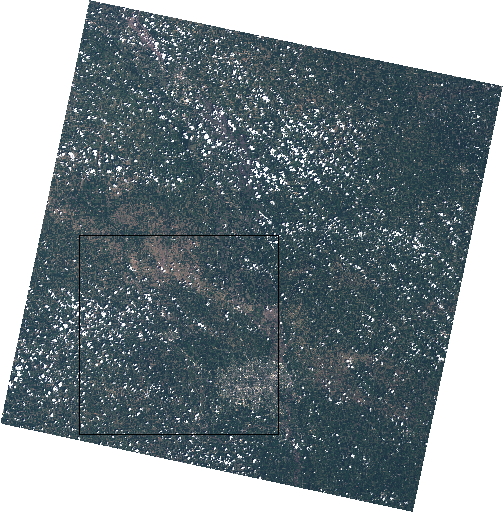

In [7]:
validation_geom = ee.Image('users/cgmorton/disalexi/LC08_028031_20140708/albedo') \
    .geometry()

# {}'min': [0.01, 0.01, 0.01], 'max': [0.4, 0.4, 0.4], 'gamma': [1.8, 1.8, 1.8]}
vis_image = landsat_img \
    .visualize(bands=['B4', 'B3', 'B2'], min=[0, 0, 0], max=[0.3, 0.3, 0.3]) \
    .reproject(crs=image_crs, crsTransform=image_transform) \
    .paint(validation_geom, color=0.5, width=1)
    # .clip(validation_geom)
Image(url=vis_image.getThumbURL(), embed=True, format='png')

### Prep the raw Landsat TOA image for use in GEE DisALEXI

The prep function will rename the bands to generic names, compute albedo, ndvi, lai, and extract the fmask image from the BQA band.

In [8]:
input_img = ee.Image(landsat.Landsat(landsat_img).prep())
mask_img = input_img.select('cfmask').eq(0)
# pp.pprint(input_img.getInfo())

Show the NDVI band for the validation asset area

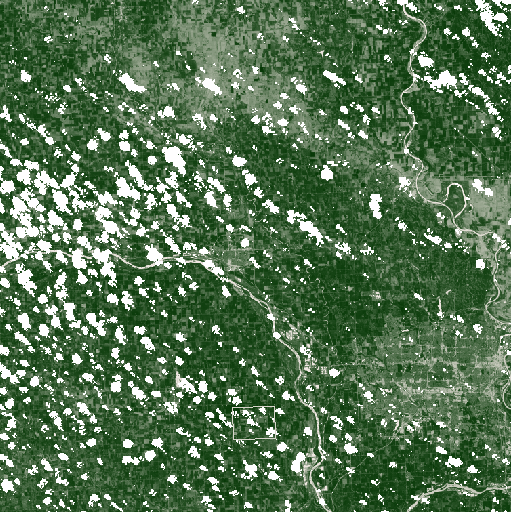

In [9]:
vis_img = input_img.select(['ndvi']).updateMask(mask_img) \
    .paint(ee.Geometry.Polygon(test_region), 'red', 1)
Image(url=vis_img.getThumbURL({
        'region': asset_region, 'min':-0.1, 'max':0.9, 'palette': ndvi_palette}), 
      embed=True, format='png')

Show the NDVI band for the test site area

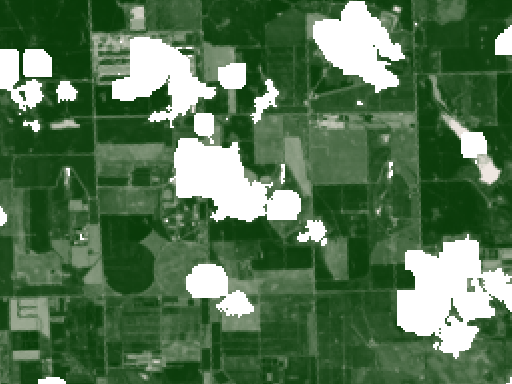

In [10]:
Image(url=input_img.select(['ndvi']).updateMask(mask_img).getThumbURL({
        'region': test_region, 'min':-0.1, 'max':0.9, 'palette': ndvi_palette}), 
      embed=True, format='png')

### Extract input values at the test point

In [11]:
print('LAI:    {:12.8f}'.format(float(
    utils.image_value(input_img, xy=ne1_xy)['lai'])))
print('NDVI:   {:12.8f}'.format(float(
    utils.image_value(input_img, xy=ne1_xy)['ndvi'])))
print('Albedo: {:12.8f}'.format(float(
    utils.image_value(input_img, xy=ne1_xy)['albedo'])))
print('LST:    {:12.8f} [K]'.format(float(
    utils.image_value(input_img, xy=ne1_xy)['lst'])))

LAI:      3.39367037
NDVI:     0.78558022
Albedo:   0.22203377
LST:    300.37899609 [K]


### Initialize the DisALEXI object

In [12]:
# Initialize the DisALEXI object using all default values
# NLCD Landcover, NED Elevation, CONUS ALEXI ET
disalexi = eedisalexi.Image(input_img, iterations=10)

### Extract the ancillary values at the test point

In [13]:
disalexi._set_alexi_et_vars()
disalexi._set_elevation_vars()
disalexi._set_landcover_vars()
disalexi._set_solar_vars()
disalexi._set_weather_vars()
print('ALEXI ET:   {:>12.8f} [mm]'.format(float(utils.image_value(
    disalexi.alexi_et, xy=ne1_xy)['alexi_et'])))
print('Elevation:  {:>12.8f} [m]'.format(float(utils.image_value(
    disalexi.elevation, xy=ne1_xy)['elevation'])))
print('Rs Hourly:  {:>12.8f} [W m-2]'.format(float(utils.image_value(
    disalexi.rs1, xy=ne1_xy)['rs'])))
print('Rs Daily:  {:>13.8f} [W m-2]'.format(float(utils.image_value(
    disalexi.rs24, xy=ne1_xy)['rs'])))
print('Wind Speed: {:>12.8f} [m/s]'.format(float(utils.image_value(
    disalexi.windspeed, xy=ne1_xy)['windspeed'])))
print('Land Cover: {:3}'.format(int(utils.image_value(
    disalexi.landcover, xy=ne1_xy)['landcover'])))

ALEXI ET:     7.28730059 [mm]
Elevation:  356.74499512 [m]
Rs Hourly:  925.85181250 [W m-2]
Rs Daily:  8506.97167969 [W m-2]
Wind Speed:   4.11969798 [m/s]
Land Cover:  82


### Compute Air Temperature

In [14]:
image_transform = landsat_img.select('B2').projection().getInfo()['transform']
# Reduce the computation resoultion
# image_transform = [120.0, 0.0, 632685.0, 0.0, -120.0, 4742715.0]

In [15]:
t_air_img = ee.Image(disalexi.compute_ta()) \
    .reproject(crs=image_crs, crsTransform=image_transform)

In [16]:
# print('Output Ta:\n{}'.format(
#     pprint.pformat(utils.image_value(t_air_img)['t_air'])))

In [17]:
t_air_url = t_air_img.getThumbURL({
    'region': test_region, 'min':280, 'max':310})
print(t_air_url)

https://earthengine.googleapis.com/api/thumb?thumbid=426cafec38b0934d4194fcf72c381185&token=937ab03d72a6fca0cf4e69caa96ff147


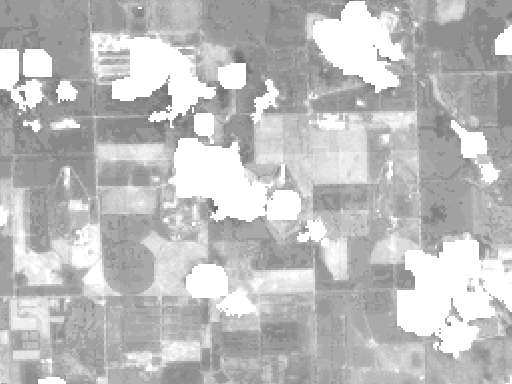

In [18]:
Image(url=t_air_url, embed=True, format='png')

### Aggregate Air Temperature to ALEXI ET cells

In [19]:
t_air_coarse_img = disalexi.aggregate(t_air_img)

In [20]:
# print('Coarse Ta: {}'.format(pprint.pformat(
#     utils.image_value(t_air_coarse_img, xy=ne1_xy, scale=1)['t_air'])))

In [21]:
# t_air_coarse_url = t_air_coarse_img.getThumbUrl({
#     'region': test_region, 'min':280, 'max':310})
# print(t_air_coarse_url)

In [22]:
# Image(url=t_air_coarse_url, embed=True, format='png')

### Compute ET

In [23]:
et_img = disalexi.compute_et(t_air_coarse_img) \
    .reproject(crs=image_crs, crsTransform=image_transform)

In [24]:
# print('ET: {}'.format(pprint.pformat(
#     utils.image_value(et_img, xy=ne1_xy)['et'])))

In [25]:
# et_url = et_img.getThumbURL({
#     'region': test_region, 'min': 0, 'max': 8, 
#     'palette': ','.join(ssebop_et_palette)})
# print(et_url)

In [26]:
# Image(url=et_url, embed=True, format='png')

### Aggregate ET to ALEXI ET cells

In [27]:
et_coarse_img = disalexi.aggregate(et_img)

In [28]:
# print('Coarse ET: {}'.format(pprint.pformat(
#     utils.image_value(et_coarse_img, xy=ne1_xy, scale=1)['et'])))

### Exports

In [29]:
tair_task = ee.batch.Export.image.toDrive(
    t_air_img,
    description='LC08_028031_20140708_c1_toa_tair',
    folder='DisALEXI',
    fileNamePrefix='LC08_028031_20140708_c1_toa_tair',
    dimensions='3000x3000',
    crs=image_crs,
    crsTransform=image_transform,
    maxPixels=1E9)

In [30]:
tair_coarse_task = ee.batch.Export.image.toDrive(
    t_air_coarse_img,
    description='LC08_028031_20140708_c1_toa_tair_coarse',
    folder='DisALEXI',
    fileNamePrefix='LC08_028031_20140708_c1_toa_tair_coarse',
    dimensions='3000x3000',
    crs=image_crs,
    crsTransform=image_transform,
    maxPixels=1E9)

In [31]:
et_task = ee.batch.Export.image.toDrive(
    et_img,
    description='LC08_028031_20140708_c1_toa_et',
    folder='DisALEXI',
    fileNamePrefix='LC08_028031_20140708_c1_toa_et',
    dimensions='3000x3000',
    crs=image_crs,
    crsTransform=image_transform,
    maxPixels=1E9)

In [32]:
et_coarse_task = ee.batch.Export.image.toDrive(
    et_coarse_img,
    description='LC08_028031_20140708_c1_toa_et_coarse',
    folder='DisALEXI',
    fileNamePrefix='LC08_028031_20140708_c1_toa_et_coarse',
    dimensions='3000x3000',
    crs=image_crs,
    crsTransform=image_transform,
    maxPixels=1E9)

In [33]:
# tair_task.start()
# tair_coarse_task.start()
# et_task.start()
# et_coarse_task.start()
# print('Tair Status:        {}'.format(tair_task.status()))
# print('Tair Coarse Status: {}'.format(tair_coarse_task.status()))
# print('ET Status:          {}'.format(et_task.status()))
# print('ET Status:          {}'.format(et_coarse_task.status()))